# INSERT TITLE

Examproject by Josefine Pedersen, Viktor Texel and Pernille Svendsen

**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Optimal taxation with government consumption](#toc1_)    
- 2. [Problem 2: Labor adjustment costs](#toc2_)    
- 3. [Problem 3: Global optimizer with refined multi-start](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

*Imports and set magics:*

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sm
from types import SimpleNamespace
from scipy import optimize

# Predefine options for all plots
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"-"})
plt.rcParams.update({'font.size': 14})

# autoreload modules when code is run. Otherwise, python will not see recent changes. 
%load_ext autoreload
%autoreload 2

# Importing our own code
from examproject import question2
q2 = question2()
from examproject import question3
q3 = question3()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Introduction

**Insert introduction**

## 1. <a id='toc1_'></a>[Problem 1: Optimal taxation with government consumption](#toc0_)


Consider a worker choosing hours of labor, $L\in[0,24]$, to maximize utility: 

$$
\begin{align*}
V(w,\tau,G)&=\max_{L\in[0,24]}\ln\left(C^{\alpha}G^{1-\alpha}\right)-\nu\frac{L^{2}}{2}\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}
$$

where 

* $C$ is *private* consumption with weight $\alpha\in(0,1)$.
* $\kappa > 0$ is the *free private* consumption component.
* $C = (1-\tau)wL$ is the *costly private* consumption component.
* $w > 0 $ is the real wage.
* $\tau \in (0,1)$ is the labor-income tax rate.
* $G > 0 $ is *government* consumption with weight $1-\alpha$.
* $\nu > 0$ is the disutility of labor scaling factor


The baseline parameters are:

$$
\begin{align*}
\alpha &= 0.5\\
\kappa &= 1.0\\
\nu &= \frac{1}{2\cdot16^2} \\
w &= 1.0 \\ 
\tau &= 0.30 \\
\end{align*}
$$

**Question 1:** Verify that the optimal labor supply choice is $L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}$, where $\tilde{w} = (1-\tau)w$, for $G\in\left\{1.0 , 2.0\right\}$.

We begin by defining the parameters and functions.

**Note:** We could not define $\tilde{w}$ in sympy, so we have called this variable $w_{tilde}$

In [38]:
# Parameters
alpha, kappa, v, w, tau, w_tilde = sm.symbols('alpha kappa v w tau w_tilde')

# Variables
G, C, L, = sm.symbols('G C L')

# Define utility function and constraint
utility = sm.ln(C**alpha * G**(1-alpha))-v*(L**2/2)
constraint = kappa + (1-tau)*w*L

# Define constraint for omega_tilde
constraint_subs = constraint.subs((1-tau)*w, w_tilde)

To find optimal labor supply we:
1. Substitute consumption for constraint in the utility function
2. Differentiate w.r.t. $L$ (labor)
3. Solve for $L$ to find $L^*$

In [39]:
# Substitute consumption for constraint in the utility function
utility_subs = utility.subs(C, constraint_subs)

# Differentiate w.r.t. L (labor):
foc = sm.diff(utility_subs, L)
foc2 = sm.simplify(foc)

# Solve for L to find L_star
L_star = sm.solve(foc2, L)
L_star[1]

(-kappa*v + sqrt(v*(4*alpha*w_tilde**2 + kappa**2*v)))/(2*v*w_tilde)

In [40]:
foc_simplify = sm.Eq(0, foc2)
foc_simplify = sm.Eq(sm.Add(foc_simplify.lhs, L*v), sm.Add(foc_simplify.rhs, L*v))
foc_simplify = sm.simplify(foc_simplify)
foc_simplify = sm.Eq(sm.Mul(foc_simplify.lhs, L*w_tilde+kappa), sm.Mul(foc_simplify.rhs, L*w_tilde+kappa))
foc_simplify = sm.Eq(sm.Mul(foc_simplify.lhs, 1/v), sm.Mul(foc_simplify.rhs, 1/v))
foc_simplify = foc_simplify.subs(L*(L*w_tilde+kappa), L**2*w_tilde+L*kappa)
foc_simplify

Eq(L**2*w_tilde + L*kappa, alpha*w_tilde/v)

In [41]:
# We define the answer, as sympy is not able to solve the equation properly
L_star_omega2 = (-kappa+sm.sqrt(kappa**2+4*alpha/v*w_tilde))/(2*w_tilde)
L_star_omega2

(-kappa + sqrt(4*alpha*w_tilde/v + kappa**2))/(2*w_tilde)

**Question 2:** Illustrate how $L^{\star}(\tilde{w})$ depends on $w$.

In [47]:
L_star_func = sm.lambdify((kappa, alpha, v, w_tilde), L_star_omega2)

w_values = np.linspace(1, 20, 100)

L_vec = []
for ws in w_values:
    tau = 0.3
    w_tilde_val = (1-tau)*ws
    L_val = L_star_func(1, 0.5, 1/(2*16**2), w_tilde_val)
    L_vec.append(L_val)

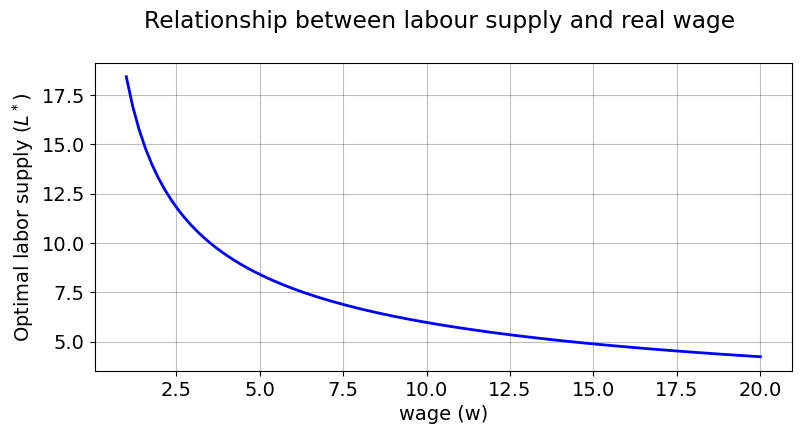

In [48]:
# We plot the figure
fig1 = plt.figure(figsize=(9, 4))
ax = fig1.add_subplot(1, 1, 1)

ax.plot(w_values, L_vec, ls='-', lw=2, color='blue')

ax.set_xlabel('wage (w)')
ax.set_ylabel('Optimal labor supply ($L^*$)')
ax.set_title('Relationship between labour supply and real wage \n');


We now consider a government, who chooses $\tau$ and spend all of the taxes on government consumption so:

$$
G = \tau w L^{\star}((1-\tau)w)
$$

**Question 3:** Plot the implied $L$, $G$ and worker utility for a grid of $\tau$-values.


In [44]:
# Define baseline parameters
par = SimpleNamespace()
par.alpha = 0.5
par.kappa = 1
par.v = 1/(2*16^2)
par.w = 1
par.tau = 0.3

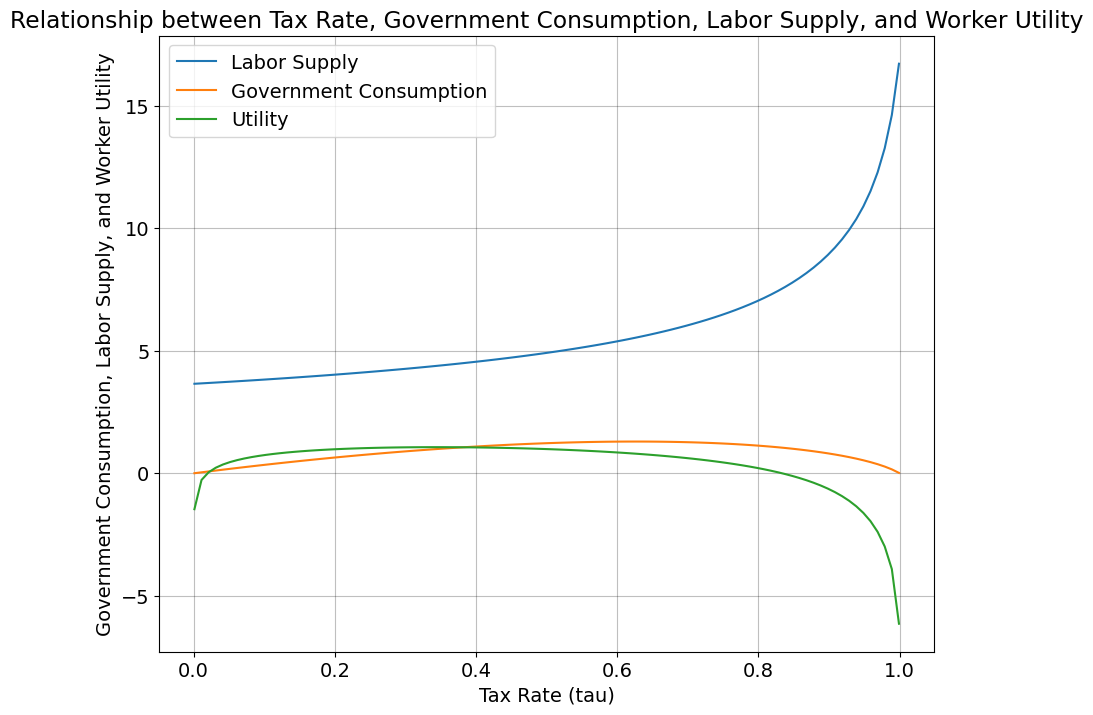

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Generate data for the plot
tau_values = np.linspace(0.001, 0.999, 100)

# Create empty lists to store the data that we are going to plot
L_vec = []
G_vec = []
tau_vec = []
utility_vec = []

for tau_val in tau_values:
    tau_vec.append(tau_val)
    w_tilde_val = (1-tau_val)*par.w
    L_val = L_star_func(par.kappa, par.alpha, par.v, w_tilde_val)
    L_vec.append(L_val)
    G_val = tau_val*par.w*L_val*((1-tau_val)*par.w)
    G_vec.append(G_val)
    u_val = np.log(G_val**(1-par.alpha)*(par.kappa+(1-tau_val)*par.w*L_val)) - par.v*(L_val**2/2)
    utility_vec.append(u_val)


# Create plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1,1,1)
ax.plot(tau_vec, L_vec, label='Labor Supply')
ax.plot(tau_vec, G_vec, label='Government Consumption')
ax.plot(tau_vec, utility_vec, label='Utility')


# Set labels and title
ax.set_xlabel('Tax Rate (tau)')
ax.set_ylabel('Government Consumption, Labor Supply, and Worker Utility')
ax.set_title('Relationship between Tax Rate, Government Consumption, Labor Supply, and Worker Utility')

# Add a legend
ax.legend()

# Show the plot
plt.show();

**Question 4:** Find the socially optimal tax rate $\tau^{\star}\in(0,1)$ maximizing worker utility. Illustrate your result.

In [50]:
utility_subs_new = utility.subs(C, constraint)
gov_cons = tau*w*L*((1-tau)*w)
utility_subs_new2 = utility_subs_new.subs(G, gov_cons)
utility_subs_new3 = utility_subs_new2.subs(L, L_star_omega2)
utility_subs_new3


-v*(-kappa + sqrt(4*alpha*w_tilde/v + kappa**2))**2/(8*w_tilde**2) + log((0.105*w**2*(-kappa + sqrt(4*alpha*w_tilde/v + kappa**2))/w_tilde)**(1 - alpha)*(kappa + w*(1 - tau)*(-kappa + sqrt(4*alpha*w_tilde/v + kappa**2))/(2*w_tilde))**alpha)

In [ ]:
# We solve FOC for tau
#foc = sm.diff(utility_subs_new3, tau)
#foc

A more general preference formulation for the worker is:

$$
\begin{align*}
\mathcal{V}(w,\tau,G)&=\max_{L\in[0,24]}\frac{\left[ \left( \alpha C^{\frac{\sigma-1}{\sigma}}+(1-\alpha) G^{\frac{\sigma-1}{\sigma}} \right)^{\frac{\sigma}{1-\sigma} }\right]^{1-\rho}-1}{1-\rho}- \nu\frac{L^{1+\varepsilon}}{1+\varepsilon},\,\,\,\varepsilon,\rho,\sigma>0,\,\,\,\rho,\sigma\neq1\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}    
$$

Optimal labor supply is now $L^{\star}(\tilde{w},G)$.

Questions 5 and 6 must be answered with the general formulation, and for 2 different set of parameters:

- Set 1:  $\sigma = 1.001$, $\rho = 1.001$ and $\varepsilon = 1.0$.
- Set 2:  $\sigma = 1.5$, $\rho = 1.5$ and $\varepsilon = 1.0 $.

**Question 5:** Find the $G$ that solves $G = \tau w L^{\star}((1-\tau)w,G)$ using the $\tau$ found in question 4.

*Hint: First write code that solves the worker problem for given values of $G$ and $\tau$. Then find the correct G based on this.*

**Question 6:** Find the socially optimal tax rate, $\tau^{\star}$, maximizing worker utility, while keeping $G = \tau w L^{\star}((1-\tau)w,G)$.

## 2. <a id='toc2_'></a>[Problem 2: Labor adjustment costs](#toc0_)

You own a hair salon. You employ hairdressers, $\ell_t$, to produce haircuts, $y_t = \ell_t$.

The wage for each hairdresser is $w$.

The demand for haircuts implies that the price of haircuts you can charge is $p_t = \kappa_t y_t^{-\eta}$, where $\kappa_t$ is a demand-shock and $\eta \in (0,1)$ measures the elasticity of demand.

Profits are:

$$
\Pi_t = p_t y_t - w \ell_t = \kappa_t \ell_t^{1-\eta} - w \ell_t
$$

Baseline parameters are:
- $\eta = 0.5$
- $w = 1.0$

**Question 1:** Verify numerically that $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ maximises profits, for $\kappa\in\left\{1.0 , 2.0\right\}$.

We solve question 1 by defining the profit function for a hairdresser, as well as the baseline parameters, afterwhich we utilize the optimize.minimize function to solve for $\ell_{t}$

In [ ]:
# Importing class
q2 = question2()

In [ ]:
# Importing class
q2 = question2()

# Define different values for kappa
kappa_vec = [1.01, 1.2, 1.4, 1.6, 1.8, 1.99]

# Check if optimal value matches given solution
q2.check_numerical(kappa_vec)

From our output above, we see that for $\kappa\in\left\{1.0 , 2.0\right\}$ profits are maximized by the equation given, i.e.: $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$. We verify this result by comparing our numerical solution with the given solution, for multiple kappa values. Hereby it is illustrated that our numerical solution gives the same l-values as the given solution.



We now consider a *dynamic* version of the model.

* The demand-shock is a so-called AR(1) in logs, 

$$
\log \kappa_{t} = \rho \log \kappa_{t-1} + \epsilon_{t},\,\,\, \epsilon_{t+1} \sim \mathcal{N}(-0.5\sigma_{\epsilon}^2,\sigma_{\epsilon})
$$

* Any hiring or firing implies a fixed adjustment cost, $\iota > 0 $.
* Future profits are discounted with a monthly factor of $R \in (0,1)$.

The initial demand shock is $\kappa_{-1} = 1$ and the planning horizon is 10 years, i.e. 120 months so $t \in \{0,1,2,\dots,119\}$. Initially you don't have any employees, $\ell_{-1}=0$


The *ex post* value of the salon is *conditional* on the shock series is:

$$
h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119}) = \left[\sum_{t=0}^{119}R^{-t}\left[\kappa_{t}\ell_{t}^{1-\eta}-w\ell_{t}-\boldsymbol{1}_{\ell_{t}\neq\ell_{t-1}}\iota\right]\right]
$$

The *ex ante* expected value of the salon can be approximated by

$$
H = \mathbb{E}[h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119})] \approx \frac{1}{K}\sum_{k=0}^{K} h(\epsilon_0^k,\epsilon_1^k,\dots,\epsilon_{119}^k)
$$

where each $k\in\{0,1,\dots,K-1\}$ is a random shock series. Maximizing profitability means maximizing $H$.


Baseline parameters are: 

- $\rho = 0.90$
- $\iota = 0.01$
- $\sigma_{\epsilon} = 0.10$
- $R = \left(1+0.01\right)^{1/12}$

**Question 2:** Calculate $H$ if the policy  $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ from question 1 is followed. Choose $K$ so the approximation is good enough to not affect your results substantially.

We calculate H under the given policy. Our seed in the demand shock is 2805 and we generate 120 random numbers, as the timeframe is 120 months. 

In [ ]:
# Calculate demand shock
log_kappa = q2.demand_shock()

# Define policy vector
l_start = np.ones(q2.par2.n)
l_vec1 = l_start[:]*(((1-q2.par2.eta)*np.exp(log_kappa))/q2.par2.w)**(1/q2.par2.eta)

# Set initial labor to 0
l_vec1[0] = 0

# Define number of shock series
K = 10

# Calculate ex-ante value
q2.ex_ante_value(K,l_vec1,do_print=True)

The ex-ante value of the salon is estimated to be 21.55. We want to choose the best possible K-value for our approximation, and therefore we check how H vary with K.

In [ ]:
# Show that different K's does not change resuts substantially
for K in range(10,105,5):
    val_salon = q2.ex_ante_value(K,l_vec1)
    print(f'K = {K:.1f} gives value = {val_salon:.2f}')

We see that H increases slightly for higher K-values. Meaning that, the more demand-shocks there are in the series, the higher the ex-ante expected value of the salon is. However, the value does not change dramatically.

Next, we consider policies on the form:

$$

\ell_{t}=\begin{cases}
\ell_t^{\ast}  & \text{if }\left|\ell_{t-1}-\ell_t^{\ast} \right|>\Delta\\
\ell_{t-1} & \text{else }
\end{cases}
\\
\text{where}\,\,\ell_t^{\ast} = \left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}} \\

$$
With $\Delta \geq 0$ and $\Delta = 0$ being the previous policy.



**Question 3:** Calculate $H$ if the policy above was followed with $\Delta = 0.05$. Does it improve profitability?

A new policy is introduced, and we want to analyze how this affects profits. We do this by calculating H under the new policy and compare it to H under the old policy for a given K value. We compare for K = 10. 

In [ ]:
# Defining the new policy vector
l_vec2 = q2.l_vec2(0.05)

# Calculate ex-ante values for different policies
new_policy = q2.ex_ante_value(10,l_vec2)
old_policy = q2.ex_ante_value(10,l_vec1)

# Compare results
print(f'Original policy: {old_policy:.2f} and new policy: {new_policy:.2f}')

From our calculations we see that the new policy improves profitability. We checked for multiple K-values. 

**Question 4:** Find the optimal $\Delta$ maximizing $H$. Illustrate your result.

In [ ]:
# Find optimal delta value
q2.value_opt(do_print=True)

In [ ]:
# Illustrate the optimal delta value
q2.delta_plot()

We find the optimal value for delta to be 0.116. This indicates that a slightly higher value of delta improves profitability for the hair salon. 
In the plot above we show the ex ante value of the hair salon for different values of delta. The optimal value is marked with a dot. 
We see that the value of the hair salon is decreasing in delta. The value of the hair salon is worthless at a delta value around 0.65. 


**Question 5:** Suggest an alternative policy you believe might improve profitability. Implement and test your policy.



In [ ]:
# Define suggested policy vector
l_vec3 = q2.l_vec3(1.5)

# Calculate ex-ante values for suggested policy
suggest_policy = q2.ex_ante_value(10,l_vec3)

# Compare results
print(f'original policy: {old_policy:.2f} and suggested policy: {suggest_policy:.2f}')

We attempt to implement an alternative policy to improve profitability. 
Like the previous question we start with zero employees. In our loop we state that if we are in the first 12 month (1 year) then the optimal amount of employees is the optimal value times a factor. After that one year we go back to the initial optimal value of employees. 

The reasoning behind this policy is that a higher number of hair dressers the first year might boost the business and get a good start and get a solid client base. After the ‘startup’ period the hair salon could down scale. 
We set the factor=1.5

The result of this implementation shows that this policy will not improve the profits.

## 3. <a id='toc3_'></a>[Problem 3: Global optimizer with refined multi-start](#toc0_)

We consider the Griewank function:

$$ f(\boldsymbol{x}) = \sum^n_{i=1} \frac{x^2_i}{4000}-\prod^n_{i=1}\cos\left(\frac{x_i}{\sqrt{i}}\right)+1$$

The **global minimum** of this function is $f(0,0) = 0$ (remember: $\cos(0)=1$).<br>
But the function also have a lot of **local minima**.

A **refined global optimizer with multi-start** is:

1. Choose *bounds* for $\mathbf{x}$ and *tolerance* $\tau > 0$.
2. Choose number of *warm-up iterations*, $\underline{K} > 0$ and *maximum number of iterations*, $K > \underline{K}$.
3. In each iteration for $k \in \{0,1,\dots,K-1\}$:

    A. Draw random $\mathbf{x}^k$ uniformly within chosen bounds.

    B. If $k < \underline{K}$ go to step E.

    C. Calculate $\chi^k = 0.50\cdot\frac{2}{1+\exp((k-\underline{K})/100)}$  

    D. Set $\mathbf{x}^{k0} = \chi^k \mathbf{x}^k + (1-\chi^k)\mathbf{x}^{\ast} $

    E. Run optimizer with $\mathbf{x}^{k0}$ as initial guess and $\mathbf{x}^{k\ast}$ as result.

    F. Set $\mathbf{x}^{\ast} = \mathbf{x}^{k\ast}$ if $k = 0$ or $f(\mathbf{x}^{k\ast}) < f(\mathbf{x}^{\ast})$

    G. If $f(\mathbf{x}^{\ast}) < \tau$ go to step 4.

4. Return the result $\mathbf{x}^{\ast}$.

As settings we choose:

* $x_1,x_2 \in  [-600,600]$
* $\tau = 10^{-8}$
* $\underline{K}=10$
* $K=1000$

The optimizer in Step 3.E is `BFGS` with a tolerance of $\tau$.

**Question 1:** Implement the refined global optimizer with multi-start. Illustrate how the effective initial guesses $\mathbf{x}^{k0}$ vary with the iteration counter $k$.

I question 1 we use inspiration from the code in the lecture note: Unconstrained optimization. 
We modify the code to fit the model considered in this problem. 

In [ ]:
# Choose bounds, tolerance, warmup and maximum iterations
bounds = [-600, 600]
tolerance = 1e-8
warmup_iters = 10
max_iters = 1000

# Run the refined global optimizer
np.random.seed(300)
result = q3.refined_global_optimizer(bounds, tolerance, warmup_iters, max_iters)

# Print the result
print("Optimal solution:", result[0])

The code above show the implementation of the refined optimizer with multi-start. We set a random seed at 300 to store one (out of many) local minima. 

In [ ]:
print("Number of iterations:", result[2])

The optimal amount of iterations with the seed being equal to 300 is 365. Note that these result would differ if not setting a seed. 

In [ ]:
# Plot how initial guess varies with the number of iterations
q3.plot_starting_guess()

The plot show the variation in the effective initial guess for each iteration. It is clear that as the number of iterations increase the values for x1 and x2 converges to the global minima of 0. 
Again, this is for the seed=300. 

**Question 2:** Is it a better idea to set $\underline{K} = 100$? Is the convergence faster?

In [ ]:
# Change the number of warmup iterations
warmup_iters = 100

# Set the seed
np.random.seed(300)

# Run the refined global optimizer for the new number of warmup iterations
result_new = q3.refined_global_optimizer(bounds, tolerance, warmup_iters, max_iters)
print("Number of iterations:", result_new[2])

In this question we check if it is preferable to set the warmup iterations to 100 instead of 10. 
With the increased amount of warmup iterations we find a slower convergence with a total amount of 471 iterations. 

# Conclusion

**INSERT TEXT**